In [1]:
# import important libraries :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models, layers, callbacks
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("D:\\ragini\\train",
shuffle=True,
image_size=(256,256),
batch_size=32)

Found 10000 files belonging to 10 classes.


In [3]:
disease = dataset.class_names
disease

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [4]:
len(dataset)

313

In [5]:
10000//32

312

In [6]:
for img,lab in dataset.take(1):
    print(img.shape)
    print(lab.numpy())

(32, 256, 256, 3)
[7 9 4 2 1 6 5 1 8 7 4 8 5 5 2 4 4 5 4 8 0 5 5 7 7 9 4 2 6 1 7 8]


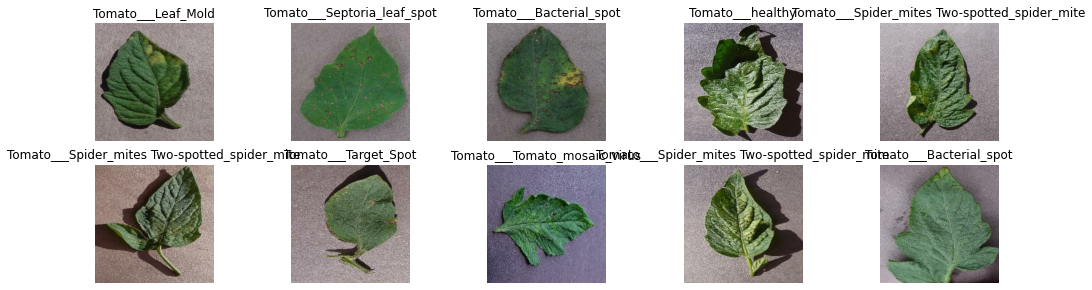

In [7]:
plt.figure(figsize=(17,10))
for img,lab in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(4,5,i+1),
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(disease[lab[i]])
        plt.axis('off')

In [8]:
len(dataset)

313

In [9]:
#80%==>training
#20%==> 10% valid,10% test

In [10]:
train_size =0.8
len(dataset)*train_size

250.4

In [11]:
313*0.8

250.4

In [12]:
train_ds = dataset.take(250)
len(train_ds)

250

In [13]:
test_ds = dataset.skip(250)
len(test_ds)

63

In [14]:
val_size=0.1
len(dataset)*val_size

31.3

In [15]:
test_ds=test_ds.skip(31)
len(test_ds)

32

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [17]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

250

In [19]:
len(val_ds)

31

In [20]:
len(test_ds)

32

In [21]:
## CACHING & PREFETCHING TO MAKE THE PIPELINE HIGH PERFORMANT :
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
# Rescaling & Resizing data for testing and smoother training.
scale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(256,256),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [23]:
# Adding custom images using data augmentation technique for better accuracy.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), 
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])

In [24]:
model = models.Sequential([
    scale,
    data_augmentation,
    # Add CNNs and maxpooling layers (trail & error work)
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.build(input_shape=(32,256,256,3))

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [26]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [29]:
his = model.fit(train_ds, epochs=30, batch_size=32, verbose=1, validation_data=val_ds)

Epoch 1/30
250/250 [==============================] - 510s 2s/step - loss: 0.1440 - accuracy: 0.9494 - val_loss: 0.5476 - val_accuracy: 0.8256
Epoch 2/30
250/250 [==============================] - 502s 2s/step - loss: 0.1574 - accuracy: 0.9477 - val_loss: 0.5381 - val_accuracy: 0.8357
Epoch 3/30
250/250 [==============================] - 504s 2s/step - loss: 0.1411 - accuracy: 0.9523 - val_loss: 0.4031 - val_accuracy: 0.8649
Epoch 4/30
250/250 [==============================] - 501s 2s/step - loss: 0.1477 - accuracy: 0.9495 - val_loss: 0.3656 - val_accuracy: 0.8800
Epoch 5/30
250/250 [==============================] - 504s 2s/step - loss: 0.1427 - accuracy: 0.9505 - val_loss: 0.3236 - val_accuracy: 0.9022
Epoch 6/30
250/250 [==============================] - 504s 2s/step - loss: 0.1224 - accuracy: 0.9560 - val_loss: 0.4813 - val_accuracy: 0.8659
Epoch 7/30
250/250 [==============================] - 512s 2s/step - loss: 0.1371 - accuracy: 0.9498 - val_loss: 0.3391 - val_accuracy: 0.8911

In [30]:
scores = model.evaluate(test_ds)

32/32 [==============================] - 46s 505ms/step - loss: 0.3096 - accuracy: 0.9141


In [31]:
scores

[0.30964595079421997, 0.9140625]

In [32]:
his.params

{'verbose': 1, 'epochs': 30, 'steps': 250}

In [33]:
his.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
loss = his.history["loss"]
val_loss = his.history["val_loss"]
acc = his.history["accuracy"]
val_acc = his.history["val_accuracy"]

Text(0.5, 1.0, 'Training & Validation Accuracy')

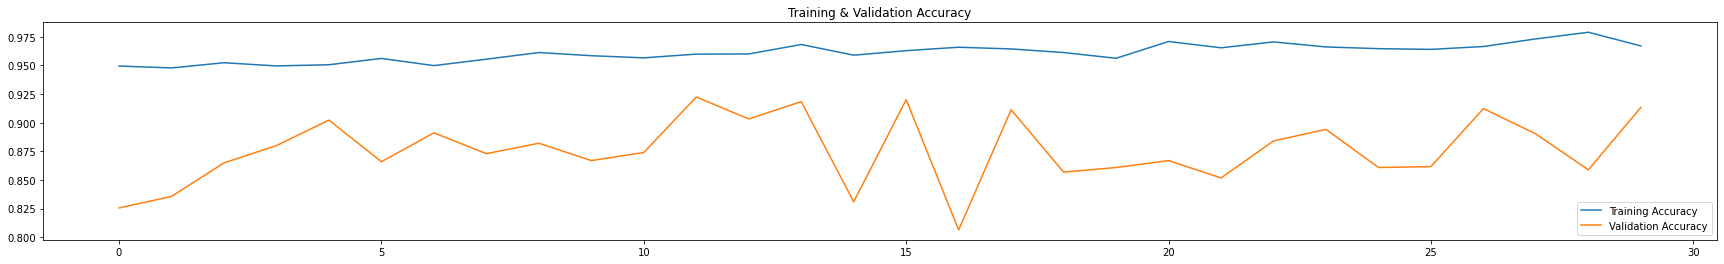

In [44]:
plt.figure(figsize=(30,4))
plt.subplot(1,1,1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title('Training & Validation Accuracy')

first image to predict
actual label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
1/1 [==============================] - 3s 3s/step
predicted label: Tomato___Tomato_Yellow_Leaf_Curl_Virus


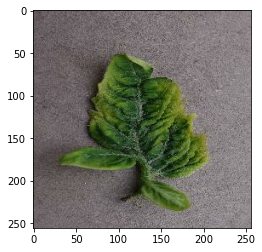

In [47]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", dataset.class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",dataset.class_names[np.argmax(batch_prediction[0])])

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = dataset.class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


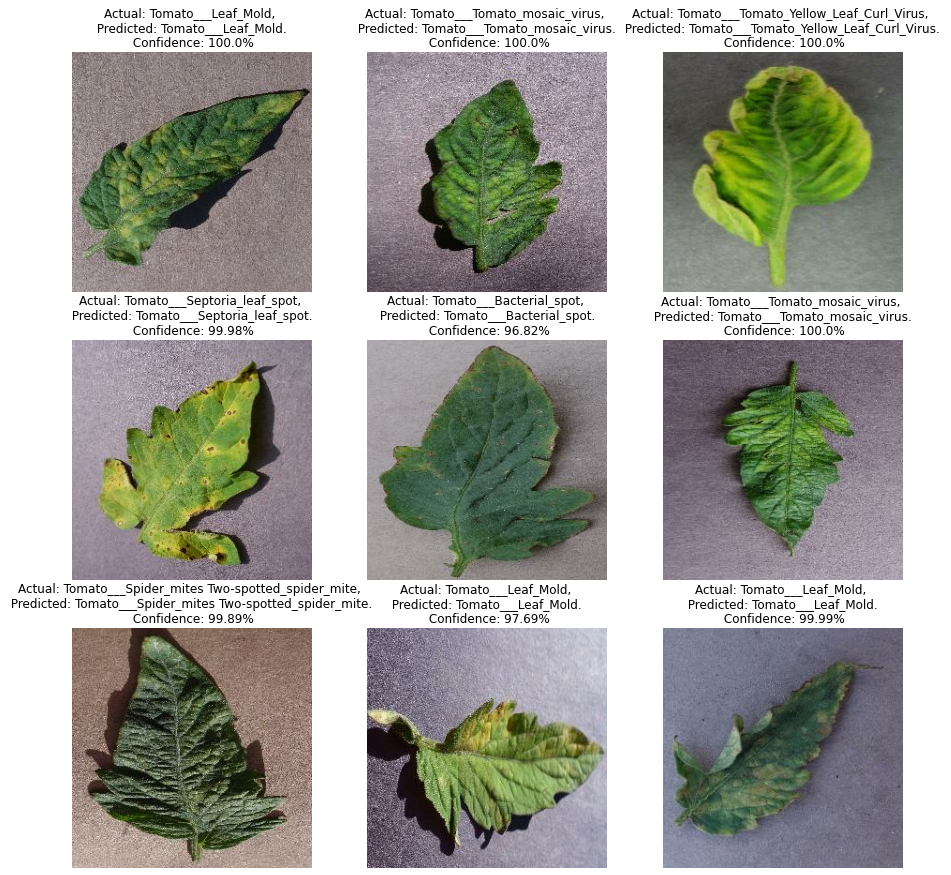

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt. subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = dataset.class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")